# Parameter estimation for a kinetic model
In this notebook, we take a closer look at different methods of parameter estimation, i.e. how to retrieve the best values for a model's parameters based on observed data.

## Exercise 1
First, we take the example of an enzyme that is reacting according to Michaelis-Menten kinetics. 

**<span style="color:lightgreen">Exercise: Try to adapt the two kinetic parameters manually to fit the model to the observed data (red).</span>**

To facilitate the search, the mean squared error is plotted as a loss surface on the right. 


In [1]:
from utils import plot_model_and_loss, KM_MIN, KM_MAX, VMAX_MIN, VMAX_MAX
from ipywidgets import interact, FloatSlider


# Interactive sliders for Vmax and Km
interact(
    plot_model_and_loss,
    Vmax=FloatSlider(min=VMAX_MIN, max=VMAX_MAX, step=0.5, value=10, description="Vmax"),
    Km=FloatSlider(min=KM_MIN, max=KM_MAX, step=0.1, value=1.4, description="Km")
);

interactive(children=(FloatSlider(value=10.0, description='Vmax', max=25.0, min=5.0, step=0.5), FloatSlider(va…

## Exercise 2

The model in our first example only had two parameters. Let's try a more complex 4-parameter function:

$f(p_1, p_2, p_3, p_4) = \sin(p_2) \cos(p_1) + (p_3 - 5)^2 - \cos^2\left(\frac{p_4}{2}\right) + 0.1 \left[ (p_2 + 8)^2 + (p_1 - 6)^2 + p_3^2 + p_4^2 \right]$

**<span style="color:lightgreen">Exercise: Below, you can change the parameter values of the slider and see how the loss function is changing with your trials. Try to minimise the loss.</span>**

In [2]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, HBox, VBox, Output

# Define the modified function that calculates the complex function value
def complex_function_array(params: tuple) -> float:
    """
    A synthetic 4-parameter function where the minimum is influenced by
    the distances of parameters from specific values.
    
    Parameters:
    - params (tuple): A tuple containing the 4 parameters (p1, p2, p3, p4).
    
    Returns:
    - float: The computed value of the function.
    """
    p1, p2, p3, p4 = params
    return (
        np.sin(p2) * np.cos(p1)  # Interactions of p1 and p2
        + (p3 - 5) ** 2          # Penalize p3 for being near 5
        - np.cos(p4 / 2) ** 2     # Nonlinear effect for p4
        + 0.1 * ((p2 + 8) ** 2 + (p1 - 6) ** 2 + p3 ** 2 + p4 ** 2)  # Penalize p1, p2, p3, p4 for being too close to zero
    )

# Initialize sliders for each parameter with specified limits
param_limits = {"p1": (-10, 10), "p2": (-10, 10), "p3": (-10, 10), "p4": (-10, 10)}
param_sliders = {
    key: FloatSlider(
        value=0.0,
        min=limits[0],
        max=limits[1],
        step=0.1,
        description=key,
        continuous_update=False  # Update only on release of slider
    )
    for key, limits in param_limits.items()
}

# Output widget to display the plot
output_plot = Output()

# Track iterations and corresponding function values
iterations = []
function_values = []

def update_plot(change=None):
    """
    Update the plot when a parameter value is changed by the user.
    
    This function retrieves the current parameter values from the sliders,
    computes the function value, appends it to the iteration history, and updates
    the plot showing the function values over iterations.
    """
    # Get current parameter values from sliders
    params = [slider.value for slider in param_sliders.values()]
    
    # Compute the current function value
    value = complex_function_array(params)
    
    # Record the iteration and function value
    iterations.append(len(iterations) + 1)
    function_values.append(value)
    
    # Update the plot with the new data
    with output_plot:
        output_plot.clear_output(wait=True)  # Clear the previous plot
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(iterations, function_values, marker='o')  # Plot the iterations vs function values
        ax.set_title("Function Value Over Iterations")  # Plot title
        ax.set_xlabel("Iteration")  # X-axis label
        ax.set_ylabel("Function Value")  # Y-axis label
        ax.grid()  # Show grid lines
        plt.show()  # Display the plot
        print(f"Function Value: {value:.3f}")  # Print the current function value
    return

# Add event listeners to the sliders to update the plot when the value changes
for slider in param_sliders.values():
    slider.observe(update_plot, names="value")

# Arrange sliders and output plot in a layout
slider_box = VBox(list(param_sliders.values()))  # Arrange sliders vertically
ui = HBox([slider_box, output_plot])  # Arrange sliders and plot horizontally

# Display the interactive UI
display(ui)


## Exercise 3: One-Factor-At-a-Time (OFAT)
Since it is cumbersome to manually guess all for parameters, we are next trying to start from an initial guess and optimise the parameters one by one. 

**<span style="color:lightgreen">Exercise: Have a look at the plot, as well as the optimial value determined by an optimisation algorithm. Why do the solutions differ?</span>**

We start with an initial guess of
p1: 1
p2: 1
p3: 1
p4: 1


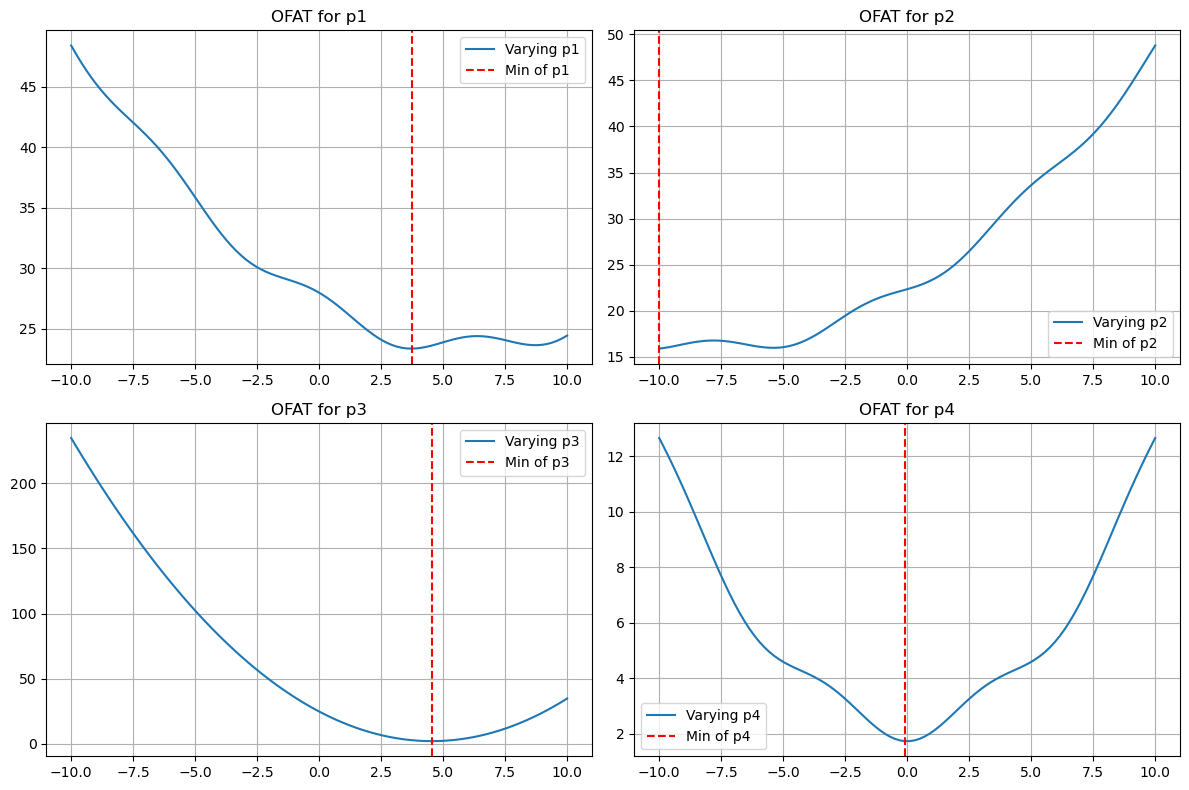

The final parameters after OFAT are
p1: 3.74
p2: -10.0
p3: 4.55
p4: -0.1
The score is 1.7379519751512378


In [3]:
from utils import visualize_ofat

# OFAT method: Start with initial guess and update parameters one by one
visualize_ofat(func=complex_function_array)

In [4]:
from scipy.optimize import minimize

# Initial guess and bounds for the parameters
initial_guess = [1, 1, 1, 1]
bounds = [(-10, 10), (-10, 10), (-10, 10), (-10, 10)]

# Perform the optimization to find the minimum
result_min = minimize(complex_function_array, initial_guess, bounds=bounds)

# Extract the minimum value and corresponding parameters
min_value = result_min.fun
min_params = result_min.x

print(f"Minimum Value: {min_value}")
print("This is the actual global minimum")
for name, value in zip(["p1", "p2", "p3", "p4"], min_params):
    print(f"{name}: {np.round(value, decimals=2)}")


Minimum Value: 0.2811863276301083
This is the actual global minimum
p1: 6.24
p2: -7.88
p3: 4.55
p4: -0.0


## Exercise 4: Grid search

One way to improve the OFAT method is to do a grid search of parameters. This means that the parameter space is equally partitioned and the points on the grid are used to evaluate function values, thus identifying the minimum.

**<span style="color:lightgreen">Exercise: Have a look at the plot below. Which limitations do you see for the method, especially in higher dimensions?</span>**

Performing 2D grid search...


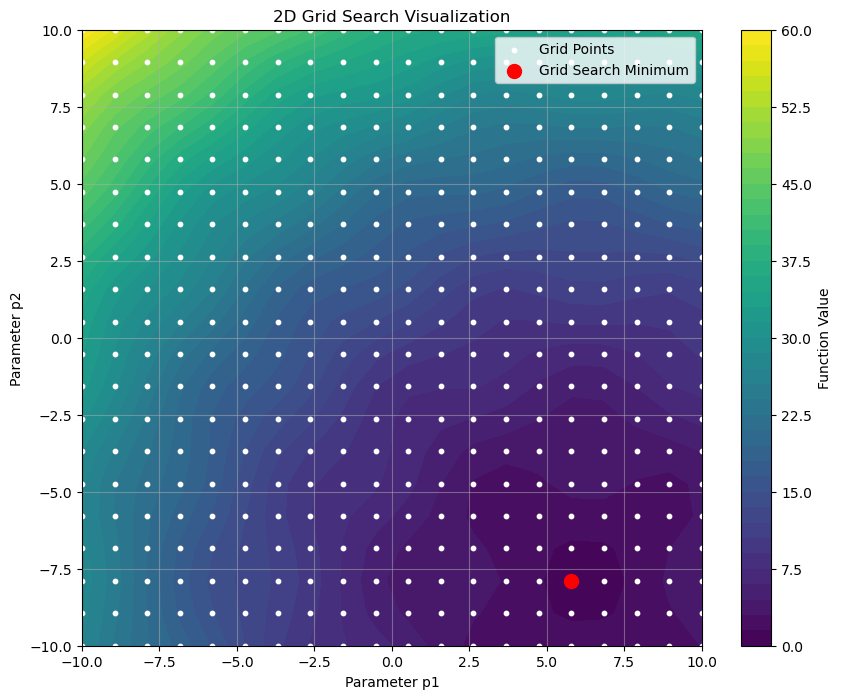

Grid Search Minimum Value: 0.6256913817474719
Minimum found at p1=5.79, p2=-7.89
Fixed parameters: p3=5, p4=0

Notice how the 2D grid search captures the landscape better than OFAT but is limited by resolution and visits many points that are not promising.


In [5]:
# Fixed parameters for p3 and p4
fixed_p3 = 5  # Optimal value for p3
fixed_p4 = 0  # Optimal or default value for p4

# Define the grid search function
def grid_search(func, param_limits, resolution=10):
    """
    Performs a grid search over the specified parameter space.

    Parameters:
    - func: The function to minimize.
    - param_limits: Dictionary containing parameter limits {name: (min, max)}.
    - resolution: The number of grid points per parameter.

    Returns:
    - min_params: The parameters corresponding to the minimum value found.
    - min_value: The minimum value found.
    """
    grids = [np.linspace(lim[0], lim[1], resolution) for lim in param_limits.values()]
    grid_mesh = np.meshgrid(*grids)
    param_combinations = np.vstack([grid.flatten() for grid in grid_mesh]).T

    min_value = float("inf")
    min_params = None
    history = []

    for params in param_combinations:
        value = func(params)
        history.append((params, value))
        if value < min_value:
            min_value = value
            min_params = params

    return min_params, min_value, history


# Define a 2D-specific function for visualization
def complex_function_2D(params: tuple) -> float:
    """
    A synthetic 2D function for grid search visualization,
    keeping p3 and p4 fixed.
    """
    p1, p2 = params
    return complex_function_array((p1, p2, fixed_p3, fixed_p4))


# Perform grid search and visualize results in 2D
def visualize_2D_grid_search():
    """
    Visualizes grid search in 2D for parameters p1 and p2
    while keeping p3 and p4 fixed.
    """
    # Parameter limits for p1 and p2
    param_limits_2D = {"p1": param_limits["p1"], "p2": param_limits["p2"]}
    resolution = 20  # Grid resolution for better visualization

    print("Performing 2D grid search...")
    min_params, min_value, history = grid_search(complex_function_2D, param_limits_2D, resolution=resolution)

    # Convert history to numpy array for easier plotting
    history_params = np.array([h[0] for h in history])
    history_values = np.array([h[1] for h in history])

    # Create a grid for contour plot
    p1_values = np.linspace(*param_limits_2D["p1"], resolution)
    p2_values = np.linspace(*param_limits_2D["p2"], resolution)
    p1_grid, p2_grid = np.meshgrid(p1_values, p2_values)
    z_values = np.array([
        complex_function_2D((p1, p2))
        for p1, p2 in zip(p1_grid.ravel(), p2_grid.ravel())
    ]).reshape(p1_grid.shape)

    # Plot the contour and grid search points
    plt.figure(figsize=(10, 8))
    plt.contourf(p1_grid, p2_grid, z_values, levels=50, cmap="viridis")
    plt.colorbar(label="Function Value")
    plt.scatter(history_params[:, 0], history_params[:, 1], c="white", s=10, label="Grid Points")
    plt.scatter(*min_params, color="red", s=100, label="Grid Search Minimum")
    plt.title("2D Grid Search Visualization")
    plt.xlabel("Parameter p1")
    plt.ylabel("Parameter p2")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

    # Display the results
    print(f"Grid Search Minimum Value: {min_value}")
    print(f"Minimum found at p1={min_params[0]:.2f}, p2={min_params[1]:.2f}")
    print(f"Fixed parameters: p3={fixed_p3}, p4={fixed_p4}")

    print("\nNotice how the 2D grid search captures the landscape better than OFAT but is limited by resolution and visits many points that are not promising.")

# Call the function to visualize 2D grid search
visualize_2D_grid_search()
